# LSTM emotion recognizer

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -qU git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12

Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [19]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [22]:
from datasets import load_dataset
emotions = load_dataset('emotion')
max_textlen = max([len(text.split(' ')) for text in emotions['train']['text']]
                 +[len(text.split(' ')) for text in emotions['validation']['text']])
print(f'Maximum text length: {max_textlen}')

Maximum text length: 66


Create the training and test datasets.

In [23]:
MAX_LEN = 128

# Training set
train_set = tokenizer(list(emotions['train']['text']), max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_label = tf.keras.utils.to_categorical(list(emotions['train']['label']), 6)

# Test set
test_set = tokenizer(list(emotions['validation']['text']), max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_label = tf.keras.utils.to_categorical(list(emotions['validation']['label']), 6)

emotion_labels = emotions['train'].features['label'].names
emotion_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Show the first training data.

In [24]:
train_text[0]

array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

Convert the first training data back to the original text.

In [25]:
' '.join(tokenizer.convert_ids_to_tokens(train_text[0]))

'[CLS] i didn ##t feel humiliated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Define the bidirectional LSTM model.

In [ ]:
lstm_model = models.Sequential(name='Bidirectional_LSTM_classifier')
lstm_model.add(layers.Input(shape=(None,), name='input_ids'))
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, name='text_embedding'))
lstm_model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True),
                                    name='bidirectional_LSTM1'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=False),
                                    name='bidirectional_LSTM2'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(256, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "Bidirectional_LSTM_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_embedding (Embedding)           │ (None, None, 512)           │      15,627,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_LSTM1 (Bidirectional)  │ (None, None, 1024)          │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_LSTM2 (Bidirectional)  │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,582,022 (86.14 MB)

 Trainable params: 22,582,022 (86.14 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [ ]:
lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [ ]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=32, epochs=10)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 87ms/step - acc: 0.3303 - loss: 1.6022 - val_acc: 0.6115 - val_loss: 1.1286
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - acc: 0.6716 - loss: 0.8844 - val_acc: 0.7950 - val_loss: 0.6236
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - acc: 0.8379 - loss: 0.4558 - val_acc: 0.8245 - val_loss: 0.5223
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - acc: 0.9117 - loss: 0.2631 - val_acc: 0.8790 - val_loss: 0.4080
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - acc: 0.9471 - loss: 0.1675 - val_acc: 0.8785 - val_loss: 0.3972
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - acc: 0.9608 - loss: 0.1225 - val_acc: 0.8825 - val_loss: 0.3785
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - acc: 0.9769 - loss: 0.0857 - val_acc: 0.8710 - val_loss: 0.4490
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - acc: 0.9717 - loss: 0.0850 - val_acc: 0.8985 - val_loss: 0.4483
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 

Plot charts for the accuracy and loss values.

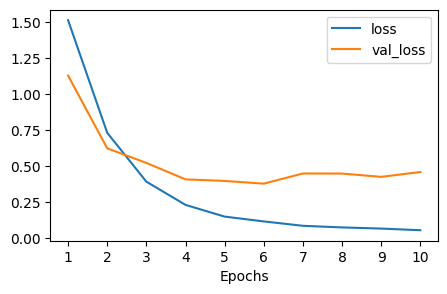

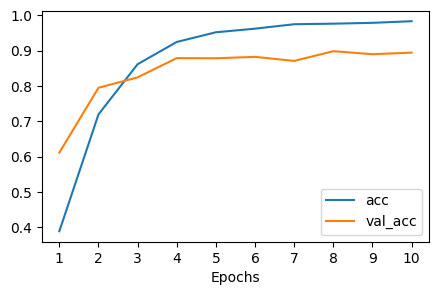

In [ ]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

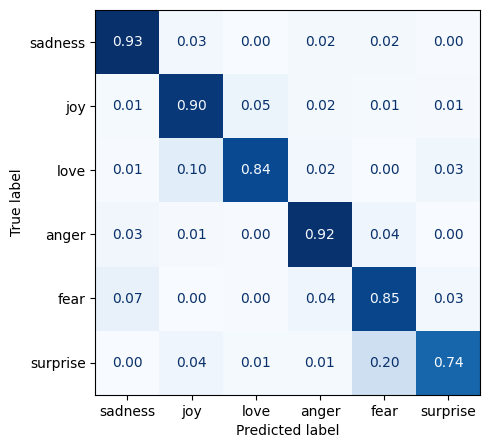

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = lstm_model.predict(test_text, verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

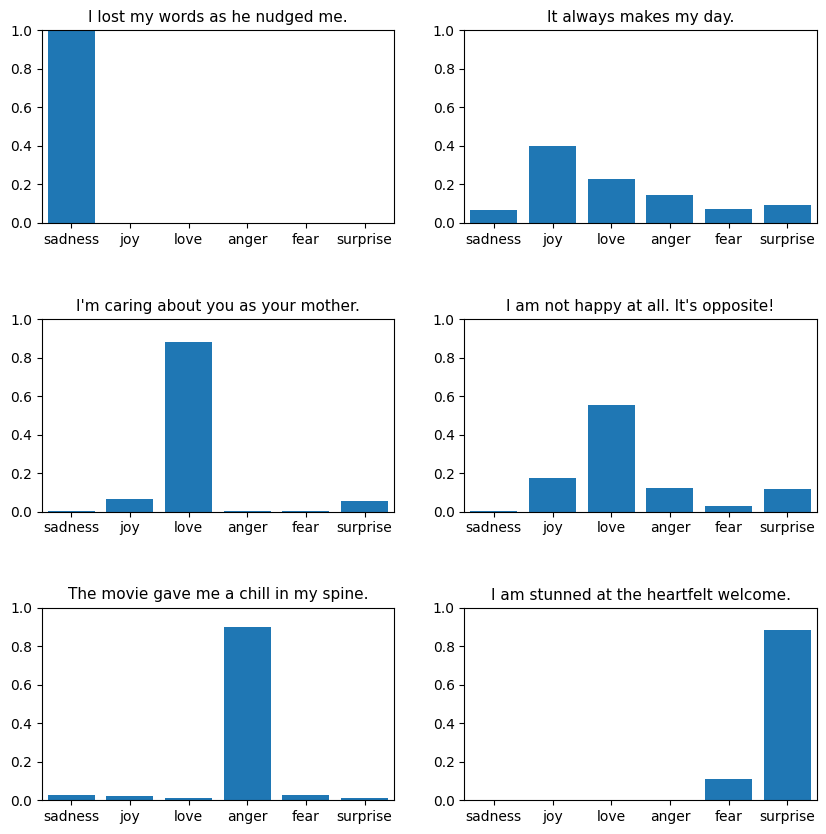

In [ ]:
input_text = [
    "I lost my words as he nudged me.",
    "It always makes my day.",
    "I'm caring about you as your mother.",
    "I am not happy at all. It's opposite!",
    "The movie gave me a chill in my spine.",
    "I am stunned at the heartfelt welcome."
]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
predictions = lstm_model.predict(input_ids, verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(3, 2, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')